<a href="https://colab.research.google.com/github/kelmnberg/kelmnberg/blob/main/Topological_Anomaly_Radar_for_Retail_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDA vs Z score analysis

In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
# You need to specify a file from the dataset, for example: 'Walmart_Sales.csv'
file_path = "Walmart_sales_analysis.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "michaelhakim/walmart-sales-analysis",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)



/tmp/ipython-input-3333714565.py:12: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'walmart-sales-analysis' dataset.


In [4]:
df.head()

,Store_Number,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2/5/2010,"1,643,691",0,42.31,2.572,211,8.106
1,1,2/12/2010,"1,641,957",1,38.51,2.548,211,8.106
2,1,2/19/2010,"1,611,968",0,39.93,2.514,211,8.106
3,1,2/26/2010,"1,409,728",0,46.63,2.561,211,8.106
4,1,3/5/2010,"1,554,807",0,46.50,2.625,211,8.106


In [5]:
df["Weekly_Sales"] = df["Weekly_Sales"].str.replace(',', '').astype(int)

In [6]:
# Convert 'Date' column to datetime objects for better plotting capabilities
df['Date'] = pd.to_datetime(df['Date'])

# **Z score**

In [7]:
import numpy as np
from scipy import stats
# Basic z-score anomaly detection
z_scores = np.abs(stats.zscore(df["Weekly_Sales"]))
anomalies = z_scores > 3
print(f"Found {anomalies.sum()} point anomalies")

Found 31 point anomalies


z score identified that there's indeed anomallies poins

In [8]:
# Calculate z-scores for each store-department combination
df['z_score'] = df.groupby('Store_Number')['Weekly_Sales'].transform(
    lambda x: np.abs(stats.zscore(x))
)

# Flag anomalies
df['is_anomaly'] = df['z_score'] > 3

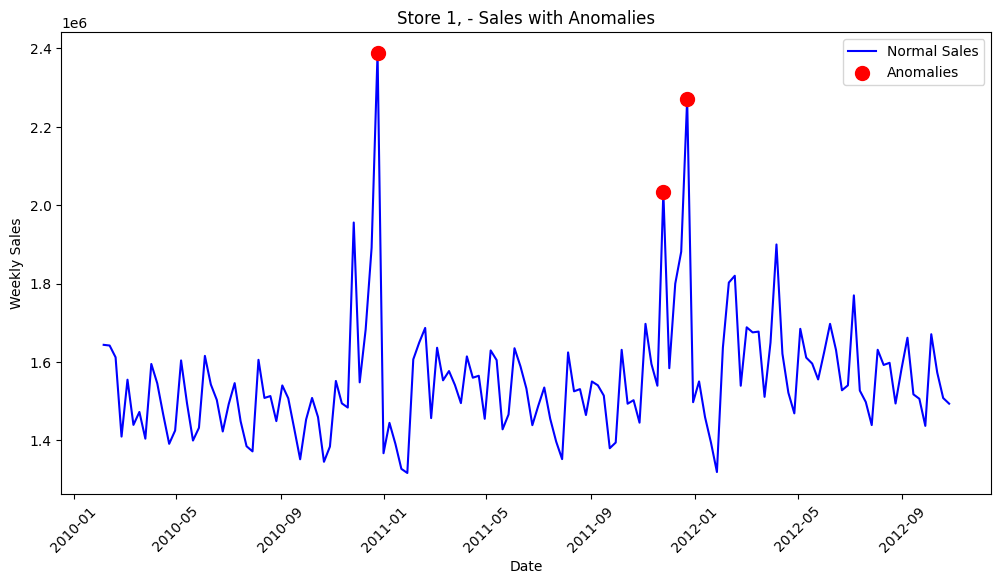

In [9]:
import matplotlib.pyplot as plt

sample_data = df[(df['Store_Number'] == 1) ]

plt.figure(figsize=(12, 6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'],
         label='Normal Sales', color='blue')

# Highlight anomalies in red
anomalies = sample_data[sample_data['is_anomaly']]
plt.scatter(anomalies['Date'], anomalies['Weekly_Sales'],
           color='red', s=100, label='Anomalies', zorder=5)

plt.title('Store 1, - Sales with Anomalies')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.show()

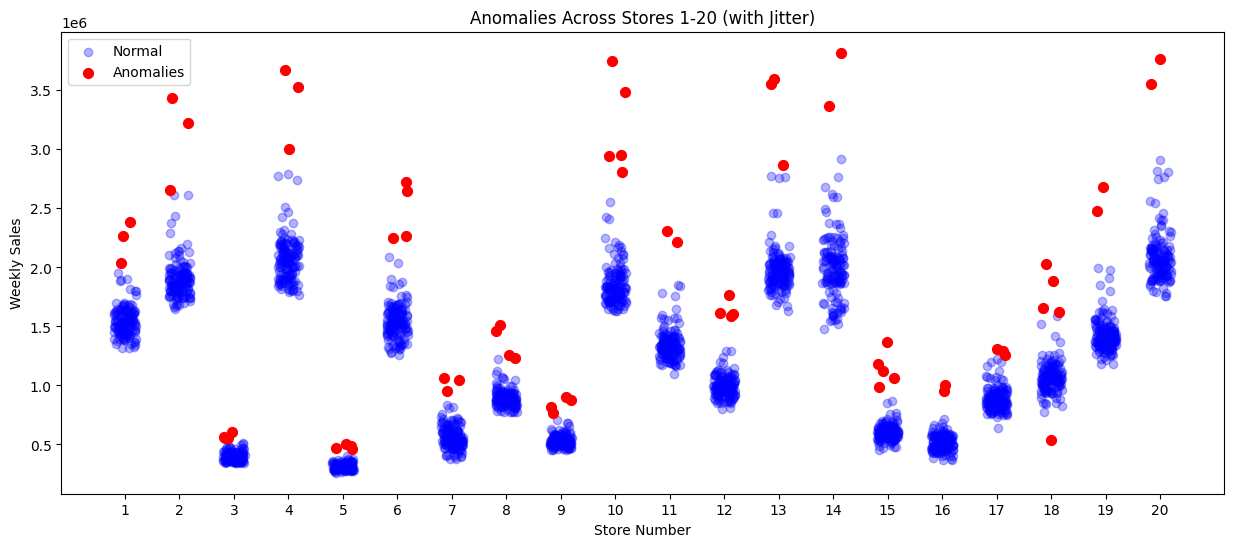

In [10]:
plt.figure(figsize=(15, 6)) # Increased width from 10 to 15

# Filter for stores 1 to 20
filtered_df = df[(df['Store_Number'] >= 1) & (df['Store_Number'] <= 20)]

# Add a small random jitter to Store_Number for better visualization of overlapping points
jitter_amount = 0.2 # Adjust this value as needed

# Normal points from filtered data with jitter
normal = filtered_df[~filtered_df['is_anomaly']].copy() # Use .copy() to avoid SettingWithCopyWarning
normal['Store_Number_Jittered'] = normal['Store_Number'] + np.random.uniform(-jitter_amount, jitter_amount, len(normal))
plt.scatter(normal['Store_Number_Jittered'], normal['Weekly_Sales'],
           alpha=0.3, label='Normal', color='blue')

# Anomaly points from filtered data with jitter
anomalies = filtered_df[filtered_df['is_anomaly']].copy() # Use .copy() to avoid SettingWithCopyWarning
anomalies['Store_Number_Jittered'] = anomalies['Store_Number'] + np.random.uniform(-jitter_amount, jitter_amount, len(anomalies))
plt.scatter(anomalies['Store_Number_Jittered'], anomalies['Weekly_Sales'],
           color='red', s=50, label='Anomalies', zorder=5)

plt.xlabel('Store Number')
plt.ylabel('Weekly Sales')
plt.title('Anomalies Across Stores 1-20 (with Jitter)')
plt.xticks(range(1, 21)) # Set x-ticks to be integers from 1 to 20
plt.legend()
plt.show()

To make these overlapping points more visible, we can introduce a technique called ***jittering***. This means adding a very small, random horizontal offset to each Store_Number when plotting. It doesn't change the actual Store_Number data, but it helps spread out the points visually so you can better see their distribution and the individual anomalies.

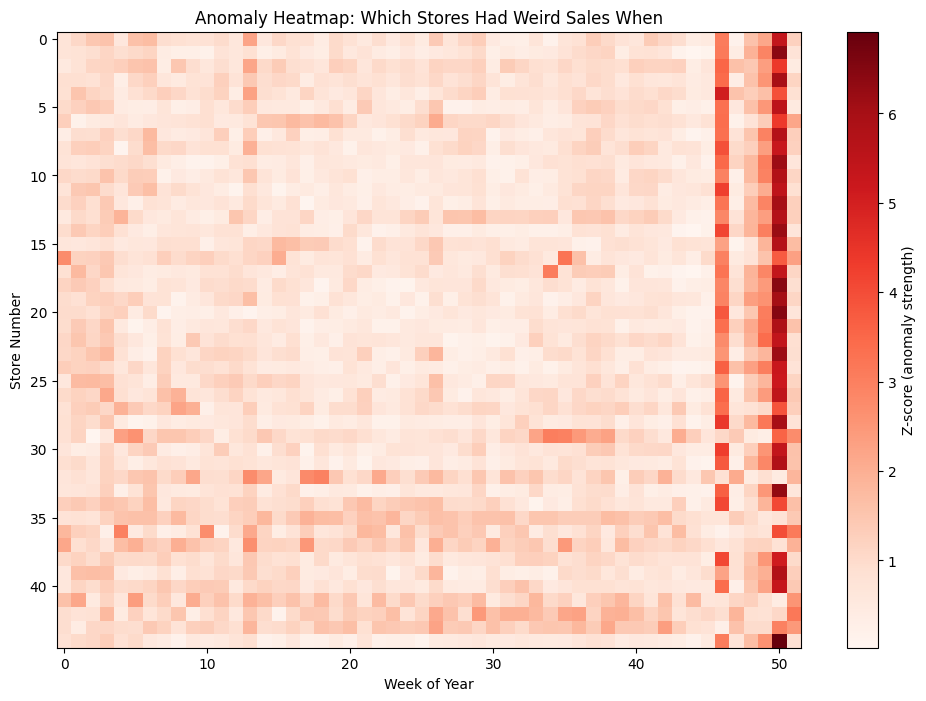

In [11]:
# Create pivot table: stores × weeks, values = z-scores
pivot_anomalies = df.pivot_table(
    values='z_score',
    index='Store_Number',
    columns=df['Date'].dt.isocalendar().week,  # Week number
    aggfunc='max'
)

plt.figure(figsize=(12, 8))
plt.imshow(pivot_anomalies, cmap='Reds', aspect='auto')
plt.colorbar(label='Z-score (anomaly strength)')
plt.xlabel('Week of Year')
plt.ylabel('Store Number')
plt.title('Anomaly Heatmap: Which Stores Had Weird Sales When')
plt.show()

In [12]:
# See exactly which store-department-date combinations are anomalous
anomaly_details = df[df['is_anomaly']][['Store_Number', 'Date', 'Weekly_Sales', 'z_score']]
print(f"Found {len(anomaly_details)} anomalies:")
print(anomaly_details.sort_values('z_score', ascending=False).head(10))

Found 135 anomalies:
      Store_Number       Date  Weekly_Sales   z_score
6338            45 2010-12-24       1682862  6.914368
2906            21 2010-12-24       1587258  6.478385
2620            19 2010-12-24       2678206  6.454855
189              2 2010-12-24       3436008  6.376394
4765            34 2010-12-24       1620748  6.272236
2048            15 2010-12-24       1368318  6.202361
3335            24 2010-12-24       2386016  6.157405
1333            10 2010-12-24       3749058  6.140812
2763            20 2010-12-24       3766687  6.034209
1762            13 2010-12-24       3595903  6.018220


In [14]:
df = df.rename(columns={' CPI ': 'CPI'})
#

# **TDA**

In [16]:

# Select the continuous features for your point cloud
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']
point_cloud = df[features].values

print(f"Point cloud shape: {point_cloud.shape}")  # Should be (n_samples, 5)

Point cloud shape: (6435, 5)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
point_cloud_standardized = scaler.fit_transform(point_cloud)

print("Means:", point_cloud_standardized.mean(axis=0))  # Should be ~0
print("Std devs:", point_cloud_standardized.std(axis=0))  # Should be ~1

Means: [ 1.28085404e-16 -1.07768409e-15  1.94336475e-16 -4.59340758e-16
  3.53339045e-17]
Std devs: [1. 1. 1. 1. 1.]


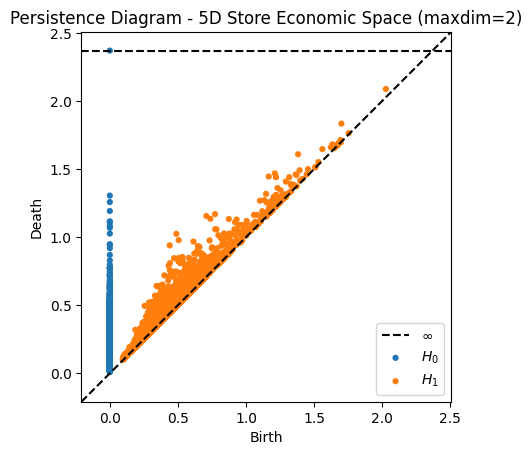

In [18]:
# 3. Run TDA
import ripser
import persim
result = ripser.ripser(point_cloud_standardized, maxdim=1) # Changed maxdim to 2
diagrams = result['dgms']

# 4. Visualize
persim.plot_diagrams(diagrams)
plt.title(f"Persistence Diagram - {len(features)}D Store Economic Space (maxdim=2)")
plt.show()

In [32]:

from scipy.spatial.distance import pdist, squareform

# Pivot to get weeks as rows, stores as columns
weekly_data = df.pivot_table(
    index='Date',           # Rows = each week
    columns='Store_Number', # Columns = each store
    values='Weekly_Sales',  # Values = sales that week
    fill_value=0
)

# Calculate correlation distance between weeks
# Weeks with similar sales patterns across all stores are "close"
distance_matrix = 1 - np.corrcoef(weekly_data)  # Weeks × Weeks matrix

print(f"Distance matrix shape: {distance_matrix.shape}")

Distance matrix shape: (143, 143)


In [28]:

'''
# NEW: Using cosine distance
from sklearn.metrics.pairwise import cosine_similarity
distance_matrix = 1 - cosine_similarity(weekly_data)

# EVERYTHING ELSE STAYS THE SAME!
result = ripser.ripser(distance_matrix, distance_matrix=True, maxdim=1)
# ... rest of your code unchanged'''

In [33]:
# Get persistence of 1-dimensional holes (loops in week connectivity)
one_dim_diagram = diagrams[1]  # 1-dimensional features

# Anomaly score = lifetime of the most persistent loop each week
# Longer persistence = more anomalous coordination
lifetimes = one_dim_diagram[:, 1] - one_dim_diagram[:, 0]  # death - birth

# Map back to weeks (this part is tricky - need to track which weeks form loops)
# SIMPLIFIED VERSION: Use maximum persistence as global anomaly indicator
max_persistence = np.max(lifetimes) if len(lifetimes) > 0 else 0

print(f"Maximum 1D persistence: {max_persistence}")

Maximum 1D persistence: 0.535910964012146


In [34]:
# Get the most persistent loop
if len(lifetimes) > 0:
    most_persistent_idx = np.argmax(lifetimes)
    most_persistent_loop = one_dim_diagram[most_persistent_idx]

    print(f"Most persistent loop: birth={most_persistent_loop[0]}, death={most_persistent_loop[1]}")
    print(f"Lifetime: {most_persistent_loop[1] - most_persistent_loop[0]}")

    # The birth scale indicates when the anomalous pattern emerged
    anomalous_scale = most_persistent_loop[0]

    # Find weeks that are far apart at this scale (simplified)
    anomalous_weeks_mask = np.mean(distance_matrix, axis=1) > anomalous_scale
    anomalous_weeks = weekly_data.index[anomalous_weeks_mask]

    print(f"Potentially anomalous weeks: {len(anomalous_weeks)}")
    print(anomalous_weeks)

Most persistent loop: birth=0.48858439922332764, death=1.0244953632354736
Lifetime: 0.535910964012146
Potentially anomalous weeks: 0
DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [35]:
# Traditional z-score anomalies (by week)
weekly_totals = weekly_data.sum(axis=1)  # Total sales each week
z_scores = np.abs((weekly_totals - weekly_totals.mean()) / weekly_totals.std())
z_anomalies = z_scores > 3

print(f"TDA anomalous weeks: {len(anomalous_weeks)}")
print(f"Z-score anomalous weeks: {z_anomalies.sum()}")

# Find weeks where TDA found something but z-score didn't
tda_specific = set(anomalous_weeks) - set(weekly_totals[z_anomalies].index)
print(f"TDA-specific anomalies: {len(tda_specific)}")

TDA anomalous weeks: 0
Z-score anomalous weeks: 4
TDA-specific anomalies: 0


In [37]:
z_anomaly_weeks = weekly_totals[z_anomalies]

print("=== Z-SCORE ANOMALIES ===")
for date, sales in z_anomaly_weeks.items():
    z_score = z_scores[date]
    print(f"{date}: Total Sales = ${sales:,.0f}, Z-Score = {z_score:.2f}")

=== Z-SCORE ANOMALIES ===
2010-11-26 00:00:00: Total Sales = $65,821,006, Z-Score = 3.44
2010-12-24 00:00:00: Total Sales = $80,931,414, Z-Score = 6.21
2011-11-25 00:00:00: Total Sales = $66,593,604, Z-Score = 3.58
2011-12-23 00:00:00: Total Sales = $76,998,240, Z-Score = 5.49


In [38]:
# Check the sales PATTERNS for those 4 weeks
print("\n=== WHY TDA IGNORED THEM ===")
for date in z_anomaly_weeks.index:
    # Get that week's sales across all stores
    week_sales = weekly_data.loc[date]

    # Check if the pattern was normal (stores maintained their relative behavior)
    store_ranks = week_sales.rank()  # Which stores were high/low that week

    # Compare to average ranks (normal pattern)
    avg_ranks = weekly_data.rank(axis=1).mean()

    # Correlation of ranks = how normal the pattern was
    pattern_correlation = store_ranks.corr(avg_ranks)

    print(f"{date}: Pattern correlation = {pattern_correlation:.3f} (1.0 = perfectly normal pattern)")


=== WHY TDA IGNORED THEM ===
2010-11-26 00:00:00: Pattern correlation = 0.977 (1.0 = perfectly normal pattern)
2010-12-24 00:00:00: Pattern correlation = 0.980 (1.0 = perfectly normal pattern)
2011-11-25 00:00:00: Pattern correlation = 0.987 (1.0 = perfectly normal pattern)
2011-12-23 00:00:00: Pattern correlation = 0.985 (1.0 = perfectly normal pattern)


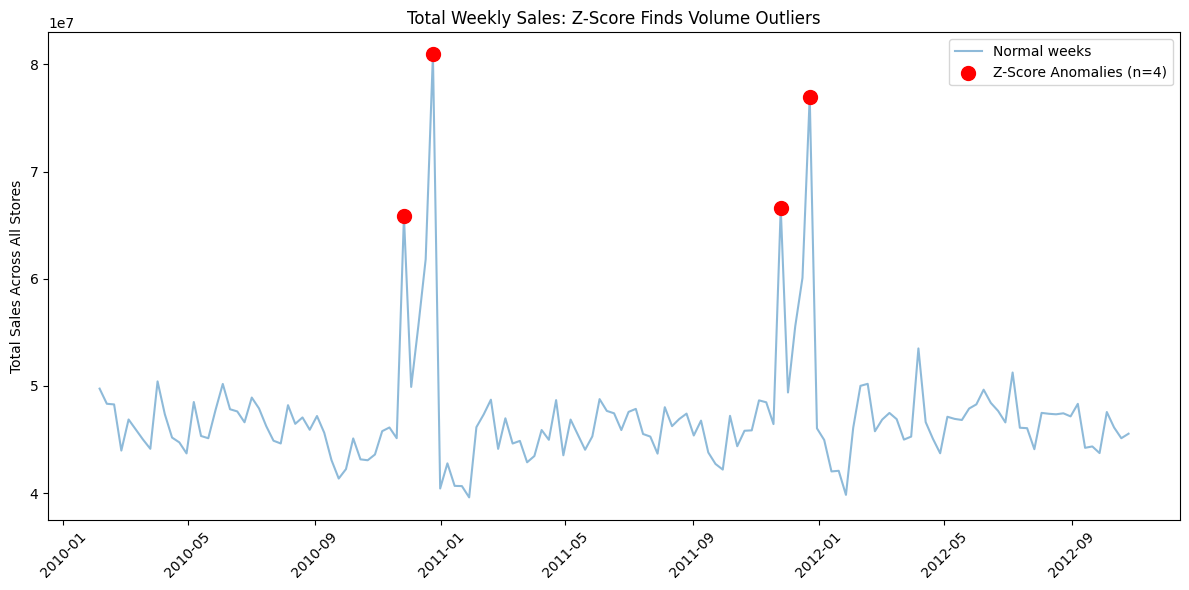

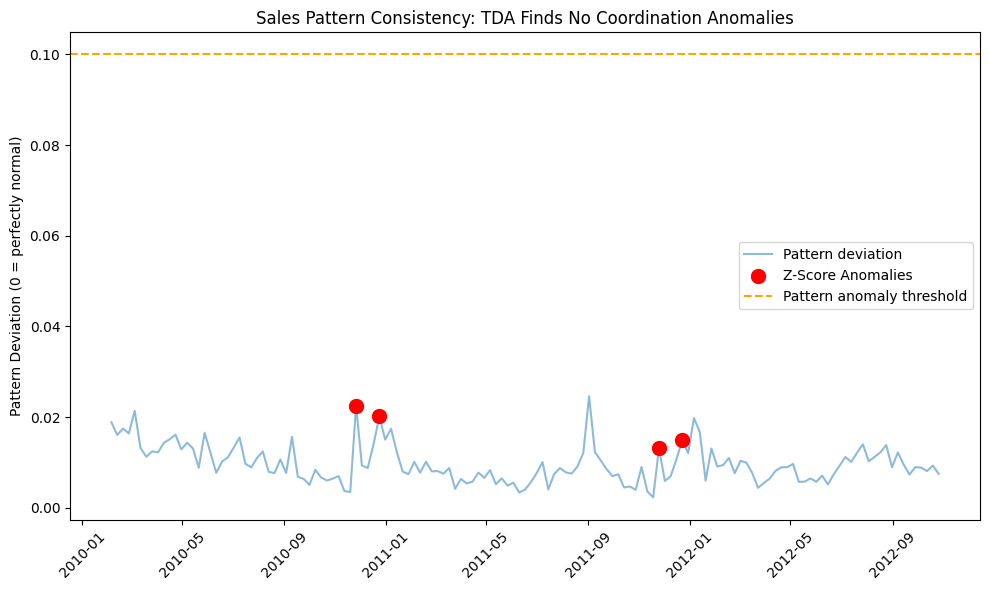

In [39]:
import matplotlib.pyplot as plt

# Plot 1: Show the 4 anomaly weeks in context
plt.figure(figsize=(12, 6))

# All weeks
plt.plot(weekly_totals.index, weekly_totals.values, alpha=0.5, label='Normal weeks')

# Highlight the 4 z-score anomalies
anomaly_dates = z_anomaly_weeks.index
anomaly_sales = z_anomaly_weeks.values
plt.scatter(anomaly_dates, anomaly_sales, color='red', s=100,
           label=f'Z-Score Anomalies (n={len(anomaly_dates)})', zorder=5)

plt.title('Total Weekly Sales: Z-Score Finds Volume Outliers')
plt.ylabel('Total Sales Across All Stores')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Show the patterns were normal
plt.figure(figsize=(10, 6))

# Calculate pattern "weirdness" for each week
pattern_deviations = []
for date in weekly_data.index:
    week_ranks = weekly_data.loc[date].rank()
    avg_ranks = weekly_data.rank(axis=1).mean()
    pattern_corr = week_ranks.corr(avg_ranks)
    pattern_deviations.append(1 - pattern_corr)  # 0 = perfectly normal pattern

pattern_deviations = np.array(pattern_deviations)

# Plot pattern deviations
plt.plot(weekly_data.index, pattern_deviations, alpha=0.5, label='Pattern deviation')

# Highlight the 4 z-score anomalies
anomaly_indices = [list(weekly_data.index).index(date) for date in anomaly_dates]
plt.scatter(anomaly_dates, pattern_deviations[anomaly_indices],
           color='red', s=100, label='Z-Score Anomalies', zorder=5)

plt.axhline(y=0.1, color='orange', linestyle='--', label='Pattern anomaly threshold')
plt.title('Sales Pattern Consistency: TDA Finds No Coordination Anomalies')
plt.ylabel('Pattern Deviation (0 = perfectly normal)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

While traditional methods flagged 4 weeks with extreme total sales, topological analysis revealed **no persistent holes or unusual connectivity patterns** in week-to-week sales behavior.

**This means:** The anomalies were isolated volume spikes/drops rather than systemic changes in how stores coordinate with each other

- **Reassuring finding:** No hidden coordination issues or chain-wide pattern disruptions
- **Resource allocation:** Focus investigation on local store factors rather than systemic issues
- **Methodological validation:** TDA provides complementary perspective to traditional anomaly detection
